In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

import pickle

In [2]:
import random
random.seed(123)

data_path = './data'

In [3]:
filename = './preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [4]:
for key in preprocessed_data:
    print(key)

x_train
y_train
x_test
y_test
le


In [5]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [6]:
# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [7]:
input_dim = x_train.shape[1]

# model hyperparameters
batch_size = 512

latent_dim = 4 

max_epochs = 10 

In [8]:
# The encoder will consist of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network, the latent space
input_data = Input(shape=(input_dim,), name='encoder_input')

# hidden layers
encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

2022-07-18 22:06:23.624048: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-18 22:06:23.624671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 22:06:23.629372: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 118)]             0         
_________________________________________________________________
encoder_1 (Dense)            (None, 96)                11424     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                6208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
encoder_3 (Dense)            (None, 48)                3120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0     

In [10]:
plot_model(
    encoder_model, 
    to_file='encoder_model.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='encoder_model.png')

In [11]:
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

# The output is the same dimension as the input data we are reconstructing
reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [12]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 118)]             0         
_________________________________________________________________
encoder_1 (Dense)            (None, 96)                11424     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                6208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
encoder_3 (Dense)            (None, 48)                3120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0   

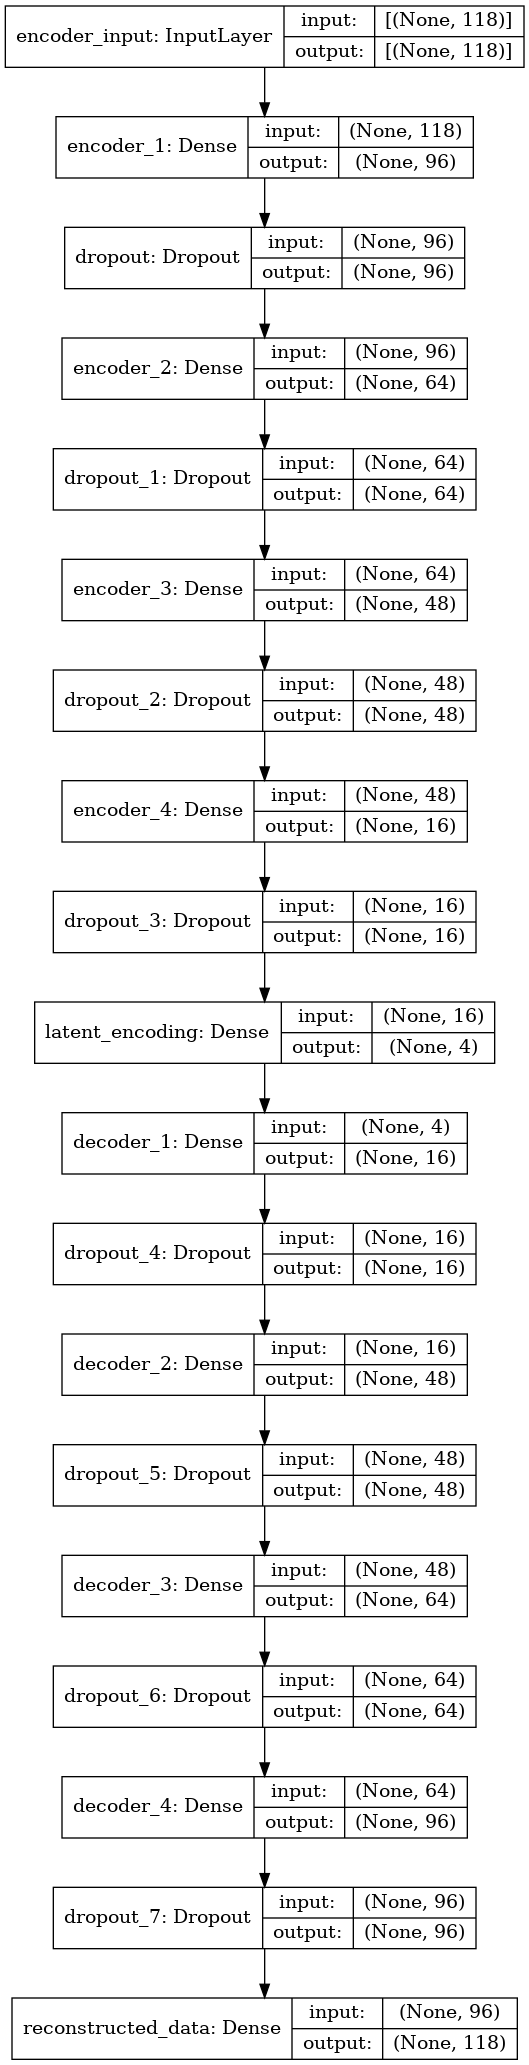

In [13]:
plot_model(
    autoencoder_model, 
    to_file='autoencoder_model.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='autoencoder_model.png')

In [14]:
opt = optimizers.Adam(lr=.00001)

autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [15]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

2022-07-18 22:06:24.711210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-18 22:06:24.716760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2419200000 Hz


Epoch 1/10
724/724 [==============================] - 52s 69ms/step - loss: 0.0860 - accuracy: 0.0039 - val_loss: 0.0524 - val_accuracy: 2.2671e-04
Epoch 2/10
724/724 [==============================] - 58s 80ms/step - loss: 0.0513 - accuracy: 0.0085 - val_loss: 0.0173 - val_accuracy: 0.0104
Epoch 3/10
724/724 [==============================] - 45s 61ms/step - loss: 0.0306 - accuracy: 0.0390 - val_loss: 0.0105 - val_accuracy: 0.0401
Epoch 4/10
724/724 [==============================] - 39s 54ms/step - loss: 0.0230 - accuracy: 0.0685 - val_loss: 0.0073 - val_accuracy: 0.0561
Epoch 5/10
724/724 [==============================] - 36s 50ms/step - loss: 0.0186 - accuracy: 0.0817 - val_loss: 0.0057 - val_accuracy: 0.0561
Epoch 6/10
724/724 [==============================] - 35s 49ms/step - loss: 0.0155 - accuracy: 0.0920 - val_loss: 0.0047 - val_accuracy: 0.0610
Epoch 7/10
724/724 [==============================] - 35s 48ms/step - loss: 0.0131 - accuracy: 0.0960 - val_loss: 0.0041 - val_accur

In [16]:
#%%js
#var url = window.location.hostname + ':6006';
#element.append(url)

In [17]:
#%tensorboard --logdir logs

In [18]:
import plotly.express as px

In [19]:
plot_df = pd.DataFrame({
    'loss': train_history.history['loss'],
    'val_loss': train_history.history['val_loss']
}, index=range(1, len(train_history.history['loss'])+1))

fig_thresh = px.line(
    plot_df, title='loss on train vs loss on validation',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=100)
fig_thresh.update_xaxes(range=[1, 10], constrain='domain')
fig_thresh.show()

In [20]:
# Reconstruct the data using our trainined autoencoder model.
x_test_recon = autoencoder_model.predict(x_test)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

In [21]:
# store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# if our reconstruction scores our normally distributed we can use their statistics
anomaly_data.describe()

recon_score
count  123505.000000
mean        0.003334
std         0.007538
min         0.000200
25%         0.000235
50%         0.000235
75%         0.001833
max         0.073574

In [22]:
pd.options.plotting.backend = 'plotly'
anomaly_data['recon_score'].plot.hist(bins=100)

In [23]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

In [24]:
le.classes_

array(['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap',
       'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap',
       'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan',
       'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster'],
      dtype=object)

In [25]:
# convert our labels to binary
binary_labels = convert_label_to_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                 24282.0  0.011608  0.010646  0.001146  0.002968  0.003550   
1                 99223.0  0.001308  0.004709  0.000200  0.000235  0.000235   

                                   
                    75%       max  
binary_labels                      
0              0.021957  0.056521  
1              0.000449  0.073574

In [26]:
# ROC
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
roc_df.index.name = "Thresholds"
roc_df.columns.name = "Rate"

fig_thresh = px.line(
    roc_df, title='ROC curve (area = %0.2f)' % roc_auc,
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1.0], constrain='domain')
fig_thresh.show()

In [27]:
# We can pick the threshold based on maximizing the true positive rate (tpr) 
# and minimizing the false positive rate (fpr)
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.039335534


In [28]:
# Or we assume our reconstructions are normally distributed and label anomalies as those
# that are a number of standard deviations away from the mean
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)

stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)

0.04103134712204337


In [29]:
# play around here and find the threshold that works for you

#thresh = optimal_threshold
thresh = stats_threshold



print(thresh)

pred_labels = (reconstruction_scores > thresh).astype(int)

results = confusion_matrix(binary_labels, pred_labels) 
print(results)

0.04103134712204337
[[24274     8]
 [99115   108]]


In [30]:
print ('Confusion Matrix: ')

def plot_confusion_matrix(confusion_matrix, target_names):
    import plotly.figure_factory as ff

    x_labels = target_names
    y_labels = target_names

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in confusion_matrix]

    # set up figure 
    fig = ff.create_annotated_heatmap(confusion_matrix, x=x_labels, y=y_labels, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>')

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()

plot_confusion_matrix(results, ['Normal','Anomaly'])

Confusion Matrix: 


In [31]:
# subset the test data so that we are only looking at the predicted anomalies
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

y_test_df = pd.DataFrame(y_test)
test_anomalies_labels = y_test_df[pred_labels.astype('bool')]

# encode the test anomalies into latent space
encoded_test_anomalies = encoder_model.predict(test_anomalies)

In [32]:
# apply KMeans to the data in order to create clusters of anomalies
kmeans = KMeans(n_clusters=10, random_state=123)
kmeans.fit(encoded_test_anomalies)

KMeans(n_clusters=10, random_state=123)

In [33]:
clusters = pd.DataFrame({'cluster':kmeans.labels_, 'label':test_anomalies_labels[0]})

most_frequent_labels = clusters.groupby('cluster').label.value_counts()

print(most_frequent_labels)

cluster  label
0        11        4
         21        1
1        17       46
2        15       31
3        6         7
         10        2
         4         1
4        20        6
5        7         2
         3         1
         8         1
         11        1
         12        1
6        1         1
         17        1
7        15        5
8        5         1
9        11        3
         21        1
Name: label, dtype: int64


In [34]:
# this dictionary will map our cluster values to the labels that appear most frequently
cluster_to_label = {}
for cluster in range(0, 10):
    label = most_frequent_labels[cluster].index[0]
    cluster_to_label[cluster] = label

# we then replace the clusters inplace by their label values
clusters.cluster.replace(cluster_to_label, inplace=True)

In [38]:
target_names = np.unique(list(clusters.label))
cm = confusion_matrix(clusters.label, clusters.cluster)
print(cm)

print ('Confusion Matrix :')

import plotly.express as px
fig = px.imshow(cm,
                labels=dict(x="Predicted", y="Actual", color="Productivity"),
                x=target_names,
                y=target_names
               )
fig.update_xaxes(side="top")
fig.show()


[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0 46  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0]]
Confusion Matrix :
